In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from glob import glob

%load_ext autoreload
%autoreload 2

In [2]:
def icon_time_to_date_time(x: float) -> pd.Timestamp:
    a = int(x // 1)
    b = x % 1 * 24*60*60
    return pd.to_datetime(a, format='%Y%m%d') + pd.DateOffset(seconds=b)

In [3]:
ds = xr.open_dataset('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllonlat_start01_new/my_atm_amip_R2B5_cpl_alllonlat_start01_new_atm_2d_ml_19790201T060000Z.nc')

In [4]:
for da_name in ds:
    print(da_name, ': ', ds[da_name].long_name)

orog :  surface altitude
ps :  surface pressure
psl :  mean sea level pressure
cosmu0 :  cosine of the zenith angle for rad. heating
rsdt :  toa incident shortwave radiation
rsut :  toa outgoing shortwave radiation
rsutcs :  toa outgoing clear-sky shortwave radiation
rlut :  toa outgoing longwave radiation
rlutcs :  toa outgoing clear-sky longwave radiation
rsds :  surface downwelling shortwave radiation
rsdscs :  surface downwelling clear-sky shortwave radiation
rlds :  surface downwelling longwave radiation
rldscs :  surface downwelling clear-sky longwave radiation
rsus :  surface upwelling shortwave radiation
rsuscs :  surface upwelling clear-sky shortwave radiation
rlus :  surface upwelling longwave radiation
ts :  surface temperature
sic :  fraction of ocean covered by sea ice
sit :  sea ice thickness
albedo :  surface albedo
clt :  total cloud cover
prlr :  large-scale precipitation flux (water)
prls :  large-scale precipitation flux (snow)
prcr :  convective precipitation flux (

In [5]:
ds_grid = xr.open_dataset('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_reference/icon_grid_0019_R02B05_G.nc')

In [6]:
files_2d_ref = sorted(glob('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_reference/my_atm_amip_R2B5_reference_atm_2d_ml_*.nc'))
files_2d_alllonlat = sorted(glob('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllonlat_start01_new/my_atm_amip_R2B5_cpl_alllonlat_start01_new_atm_2d_ml_*.nc'))
files_2d_alllonlat_wpr = sorted(glob('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllonlat_with-qr-qs_start01/my_atm_amip_R2B5_cpl_alllonlat_with-qr-qs_start01_atm_2d_ml_*.nc'))
files_2d_alllon_troplat = sorted(glob('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllon_troplat_start01/my_atm_amip_R2B5_cpl_alllon_troplat_start01_atm_2d_ml_*.nc'))
files_2d_alllon_troplat_wpr = sorted(glob('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllon_troplat_with-qr-qs_start01/my_atm_amip_R2B5_cpl_alllon_troplat_with-qr-qs_start01_atm_2d_ml_*.nc'))

len(files_2d_ref), len(files_2d_alllonlat), len(files_2d_alllonlat_wpr), len(files_2d_alllon_troplat), len(files_2d_alllon_troplat_wpr), 

(741, 217, 189, 736, 736)

In [7]:
sim_names = [
    'reference',
    'alllonlat',
    'alllonlat_wpr',
    'alllon_troplat',
    'alllon_troplat_wpr',
]

In [8]:
file_lists = [
    files_2d_ref,
    files_2d_alllonlat,
    files_2d_alllonlat_wpr,
    files_2d_alllon_troplat,
    files_2d_alllon_troplat_wpr,
]

In [9]:
def rad2degr(x):
    return x*180/np.pi

def plot_icon_tricolor(ax, clon_bnds, clat_bnds, vals, **kwargs):
    a = rad2degr(clon_bnds.flatten()[:])
    b = rad2degr(clat_bnds.flatten()[:])
    c = np.arange(clon_bnds.size).reshape(clon_bnds.shape)
    plot = ax.tripcolor(a,
                        b,
                        c,
                        vals,
                        **kwargs)
    
    return plot

In [10]:
def fix_periodicity_for_triplot(clon_bnds):
    '''
    Takes in clon bnds coordinate list and adds/subtracts 2pi
    to/from all points where one edge is with other sign
    '''
    mask = np.any(np.abs(np.diff(clon_bnds, axis=1)) > 4, axis=1)
    vert_sign_sum = np.sum(np.sign(clon_bnds), axis=1)
    pmask = np.sign(vert_sign_sum)[:,None] > np.sign(clon_bnds)
    pmask = pmask & mask[:,None]
    nmask = np.sign(vert_sign_sum)[:,None] < np.sign(clon_bnds)
    nmask = nmask & mask[:,None]

    clon_bnds[pmask] += 2*np.pi
    clon_bnds[nmask] -= 2*np.pi
    return clon_bnds

In [12]:
def calc_zonal_mean(ds, var, points=256, exponent=1):
    hist_opts = dict(bins=points, range=(-np.pi / 2, np.pi / 2))
    cells_per_bin, lat_bins = np.histogram(ds.clat, **hist_opts)
    lat_bins_c = (lat_bins[:-1] + lat_bins[1:] ) / 2
    varsum_per_bin, _ = np.histogram(ds.clat, weights=ds[var].isel(time=0)**exponent, **hist_opts)
    zonal_mean = varsum_per_bin / cells_per_bin
    return zonal_mean, lat_bins_c

def calc_zonal_mean_std(ds, var, points=256):
    mean_var, lat_bins_c = calc_zonal_mean(ds, var, points=points)
    mean_var_2, lat_bins_c = calc_zonal_mean(ds, var, points=points, exponent=2)
    return mean_var, np.sqrt(mean_var_2 - mean_var**2), lat_bins_c

In [13]:
def calc_global_mean_std(ds, var):
    mean_var = np.mean(ds[var].values * ds_grid.cell_area.values / ds_grid.cell_area.values.mean())
    mean_var_2 = np.mean(ds[var].values**2 * ds_grid.cell_area.values / ds_grid.cell_area.values.mean())
    return mean_var, np.sqrt(mean_var_2 - mean_var**2)

In [14]:
from scipy.ndimage import laplace

def calc_laplacian_variance(ds, var):
    # Apply the Laplacian operator
    laplacian = laplace(ds[var].values)
    # Compute the variance
    variance = laplacian.var()
    return variance

In [15]:
def calc_global_entropy(ds, var, range=None):
    marg = np.histogram(np.ravel(ds[var].values), bins = 100, range=range)[0]/ds[var].values.size
    marg = marg[marg > 0]
    entropy = -np.sum(np.multiply(marg, np.log2(marg)))
    return entropy

In [17]:
# timesteps = [6, int(15*24/4), int(30*24/4)]
timesteps = ['19790201T060000Z', '19790205T000000Z', '19790301T000000Z']
# timesteps = ['19790201T060000Z', '19790201T182400Z', '19790301T060000Z']
print(timesteps)
ds_list = []
ds_latlon_list = []
used_files_list = []
for i,f_list in enumerate(file_lists):
    ds_list.append([])
    ds_latlon_list.append([])
    for j,timestep in enumerate(timesteps):
        timestep_mask = [timestep in f for f in f_list]
        idx = np.argmax(timestep_mask)
        if timestep_mask[idx]:
        # if len(f_list) > timestep:
            # ds = xr.open_dataset(f_list[timestep])
            used_files_list.append(f_list[idx])

            ds = xr.open_dataset(f_list[idx])
            ds['clon_bnds'] = ds_grid['clon_vertices'].rename({'cell': 'ncells'})
            ds['clat_bnds'] = ds_grid['clat_vertices'].rename({'cell': 'ncells'})

            ds = ds.assign_coords({
                'clon_bnds': ds['clon_bnds'],
                'clat_bnds': ds['clat_bnds']}
            )
            ds_list[i].append(ds)
            # ds_latlon_list[i].append(xr.open_dataset(f_list[idx].replace('.nc', '_0.9latlon.nc')))
            ds_latlon_list[i].append(xr.open_dataset(f_list[idx].replace('.nc', '_gauss101.nc')))
        else:
            print(f'Skipping timestep {timestep} for i={i}')
            ds_list[i].append(None)
            ds_latlon_list[i].append(None)

['19790201T060000Z', '19790205T000000Z', '19790301T000000Z']
Skipping timestep 19790205T000000Z for i=2
Skipping timestep 19790301T000000Z for i=2


Maximum zonal mean plus std:  63.93555818566078
Min val / Max val:  0.31225827 78.093056


  0%|          | 0/15 [00:00<?, ?it/s]

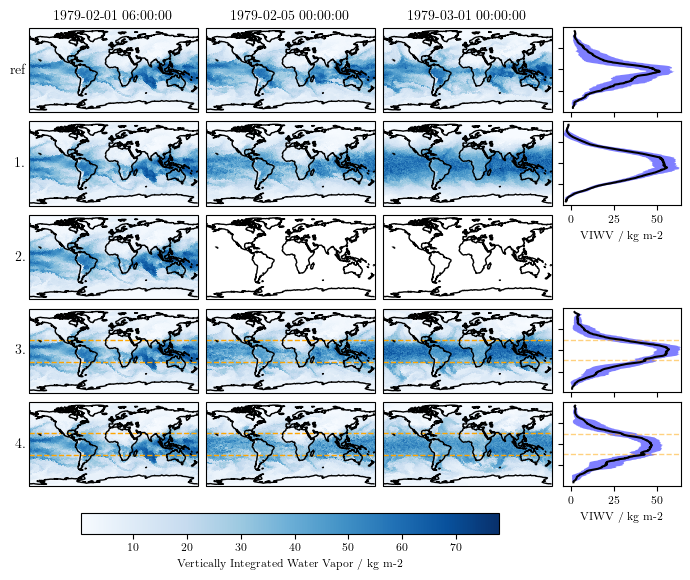

In [36]:
from tqdm.contrib import itertools
from matplotlib.gridspec import GridSpec
from convection_param.setup_mpl_tex import setup_mpl_tex, set_size 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import NullFormatter

trop_cap = 23.43615

setup_mpl_tex()

current_cmap = plt.get_cmap(name='Blues').copy()
current_cmap.set_bad(color='#bcb5bb')
qual_colormap = plt.get_cmap("tab10")

figsize = list(set_size('textwidth'))
# figsize[0] = figsize[0] / 4 * 3
figsize[1] += 1.5

fig, axes = plt.subplots(5,3,subplot_kw=dict(projection=ccrs.PlateCarree()),constrained_layout=True,
                         figsize=figsize, )#(6.4*1,5.8*1))

clon = ds.clon.values
clat = ds.clat.values
clon_bnds = ds.clon_bnds.values
clat_bnds = ds.clat_bnds.values
clon_bnds = fix_periodicity_for_triplot(clon_bnds)
val_list = [ds.prw.values.squeeze() if ds != None else None for dss in ds_list for ds in dss]

zon_mean_std_list = [calc_zonal_mean_std(ds, 'prw') if ds != None else None for dss in ds_list for ds in dss]
max_zon_meanpstd = max([np.max(x[0]+x[1]) for x in zon_mean_std_list if x is not None])
print('Maximum zonal mean plus std: ', max_zon_meanpstd)
# glob_mean_std_list = [calc_global_mean_std(ds, 'prw') if ds != None else None for dss in ds_list for ds in dss]

# val_list = [(vals-ref_ds_list[i//5].prw.values.squeeze()) if vals is not None else None for i,vals in enumerate(val_list)]

min_val = max([np.min(vals) for vals in val_list if vals is not None])
max_val = max([np.max(vals) for vals in val_list if vals is not None])
print('Min val / Max val: ', min_val, max_val)

sim_names_short = ['a)','b)','c)','d)','e)','f)','g']
sim_names_short = ['ref','1.','2.','3.','4.','f)','g']

# ylims = []
titles = []
k = 0
for i,j in itertools.product(range(5), range(3)):
    # ds = ds_list[i][j]
    vals = val_list[k]
    ax = axes[i,j]
    

    ax.set_rasterization_zorder(0)
    if vals is not None:
        # vals = (ds.rsdt - ds.rsut - ds.rlut).values.squeeze()
        # mapplot = ds_latlon_list[i][j].prw.plot(ax=ax, cmap='Blues', add_colorbar=False, vmin=min_val, vmax=max_val); ax.set_title('')
        mapplot = plot_icon_tricolor(ax,
                                     clon_bnds,
                                     clat_bnds,
                                     vals,
                                     cmap=current_cmap,
                                     vmin=min_val,
                                     vmax=max_val,
                                     zorder=-1)

        # ax.gridlines(draw_labels=False)
        if 'troplat' in sim_names[i]:
            ax.axhline(-trop_cap, ls='--', c='orange', zorder=1, lw=1)
            ax.axhline(trop_cap, ls='--', c='orange', zorder=1, lw=1)
        if j==2:
            ax2=inset_axes(ax, width="100%", height="100%", 
                 bbox_to_anchor=(1.1, 0.07, 0.7, 1),
                 bbox_transform=ax.transAxes)
            
            mean_prw, std_prw, lat = zon_mean_std_list[k]
            ax2.plot(mean_prw, lat*180/np.pi, color='black')
            ax2.fill_betweenx(lat*180/np.pi, mean_prw-std_prw, mean_prw+std_prw, facecolor='blue', alpha=0.5)
            ax2.set_yticklabels([])
            ax2.set_xlim(-5, max_zon_meanpstd)
            # ax2.set_xlim(-90, 90)
            # ax2.set_ylabel('VIWV / kg m-2', fontsize='x-small')
            # ax2.yaxis.tick_right(); ax2.yaxis.set_label_position("right")
            if i == 4 or i == 1:
                ax2.set_xlabel('VIWV / kg m-2')
            else:
                ax2.set_xticklabels([])
                
            if 'troplat' in sim_names[i]:
                ax2.axhline(-trop_cap, ls='--', alpha=0.5, c='orange', zorder=1, lw=1)
                ax2.axhline(trop_cap, ls='--', alpha=0.5, c='orange', zorder=1, lw=1)

    else:
        mapplot = plot_icon_tricolor(ax,
                                     clon_bnds,
                                     clat_bnds,
                                     np.full_like(clon, np.nan),
                                     zorder=-1)
    if i==0:
        title_obj = ax.set_title(f'{icon_time_to_date_time(ds_list[0][j].time.item())}', fontsize=10, zorder=1)
        titles.append(title_obj)
    if j==0:
        ax.text(x=-0.02, y=0.5, s=sim_names_short[i], rotation=None, ha='right', va='center', fontsize=10, transform=ax.transAxes, zorder=1)

    ax.coastlines()
    k += 1
    
fig.colorbar(mapplot, orientation='horizontal', ax=axes.ravel().tolist(), shrink=0.8, label=r'Vertically Integrated Water Vapor / kg m-2')

# fig.savefig('../../Figures/Pdfplots/VIWV_comparison_start01_zonalcol.pdf', dpi=150, bbox_inches='tight')

plt.show()